In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

class BacktesterWithoutScaling:
    """
    Backtester with vectorized swing detection (minor pivots) and configurable lag/window.
    """
    def __init__(self, data: pd.DataFrame, lag: int, window: int, ):
        """
        :param data: DataFrame with ['o','h','l','c'] indexed by datetime
        :param lag: number of bars to lag swing detection (avoids lookahead)
        :param window: half-window size for centered swing detection
        """
        self.lag = lag
        self.window = window
        self.data = data.copy()
        self.bt = None
        self.results = []
        self.process_all()

    def process_all(self):
        self.compute_vectorized_swings()
        self.map_swing_levels()
        self.calculate_liquidity_grabs()
        self.generate_entry_signals()

    def compute_vectorized_swings(self):
        span = 2 * self.window + 1
        max_h = self.data['h'].rolling(window=span, center=True, min_periods=1).max()
        min_l = self.data['l'].rolling(window=span, center=True, min_periods=1).min()
        self.data['is_swing_high'] = (self.data['h'] == max_h).shift(self.lag)
        self.data['is_swing_low']  = (self.data['l'] == min_l).shift(self.lag)

    def map_swing_levels(self):
        self.data['swing_high_level'] = (
            pd.Series(np.where(self.data['is_swing_high'], self.data['h'], np.nan),index=self.data.index).ffill()
        )
        self.data['swing_low_level'] = (
            pd.Series(np.where(self.data['is_swing_low'], self.data['l'], np.nan),index=self.data.index).ffill()
        )

    def calculate_liquidity_grabs(self):
        conds = [
            self.data['l'] < self.data['swing_low_level'],
            self.data['h'] > self.data['swing_high_level']
        ]
        choices = ['Bearish_Grab', 'Bullish_Grab']
        self.data['liquidity_grab'] = np.select(conds, choices, default=None)

    def generate_entry_signals(self):
        grab_prev = self.data['liquidity_grab'].shift(1)
        bull = (grab_prev == 'Bearish_Grab') & (self.data['c'] > self.data['o'])
        bear = (grab_prev == 'Bullish_Grab') & (self.data['c'] < self.data['o'])
        self.data['entry_signal'] = np.where(bull, 1, np.where(bear, -1, 0))

    def run_backtest(self):
        results = []
        in_position = False
        position = 0
        entry_price = None
        entry_time = None
        SL_price = None
        data = self.data
        for i in range(1, len(data)):
            signal = data['entry_signal'].iloc[i]
            open_price = data['o'].iloc[i]
            high = data['h'].iloc[i]
            low = data['l'].iloc[i]
            time_now = data.index[i]
            entry_candle_height = open_price - low if signal == 1 else high - open_price
            if not in_position and signal != 0:
                position = signal
                entry_price = open_price
                entry_time = time_now
                SL_price = entry_price - (entry_candle_height) if position == 1 else entry_price + (entry_candle_height)
                in_position = True
            elif in_position:
                sl_hit = (low <= SL_price) if position == 1 else (high >= SL_price)
                reverse_signal = (signal != 0 and signal != position)
                if sl_hit:
                    exit_price = SL_price
                    exit_time = time_now
                    pnl = (exit_price - entry_price) * position
                    results.append({
                        'Entry Time': entry_time,
                        'Exit Time': exit_time,
                        'Direction': 'Long' if position == 1 else 'Short',
                        'Entry Price': entry_price,
                        'Exit Price': exit_price,
                        'PnL': pnl,
                        'Exit Reason': 'SL Hit',
                        'SL Price': SL_price
                    })
                    in_position = False
                    position = 0
                elif reverse_signal:
                    exit_price = open_price
                    exit_time = time_now
                    pnl = (exit_price - entry_price) * position
                    results.append({
                        'Entry Time': entry_time,
                        'Exit Time': exit_time,
                        'Direction': 'Long' if position == 1 else 'Short',
                        'Entry Price': entry_price,
                        'Exit Price': exit_price,
                        'PnL': pnl,
                        'Exit Reason': 'Signal Reversed',
                        'SL Price': SL_price
                    })
                    position = signal
                    entry_price = open_price
                    entry_time = time_now
                    SL_price = low if position == 1 else high
                    in_position = True
        self.results = results
        self.bt = pd.DataFrame(results)
        if not self.bt.empty:
            self.bt['Cumulative PnL'] = self.bt['PnL'].cumsum()
            self.bt['Entry Time'] = pd.to_datetime(self.bt['Entry Time'])
            self.bt['Exit Time'] = pd.to_datetime(self.bt['Exit Time'])
            self.bt['Duration'] = (self.bt['Exit Time'] - self.bt['Entry Time']).dt.total_seconds() / 60

    
        
    def calculate_mae_mfe(self):
        if self.bt is None or self.bt.empty:
            print("Run backtest first.")
            return
        mae_list = []
        mfe_list = []
        for idx, row in self.bt.iterrows():
            entry_time = row['Entry Time']
            exit_time = row['Exit Time']
            entry_price = row['Entry Price']
            direction = 1 if row['Direction'] == 'Long' else -1
            trade_data = self.data.loc[entry_time:exit_time]
            if direction == 1:
                min_low = trade_data['l'].min()
                max_high = trade_data['h'].max()
                mae = min_low - entry_price
                mfe = max_high - entry_price
            else:
                max_high = trade_data['h'].max()
                min_low = trade_data['l'].min()
                mae = entry_price - max_high
                mfe = entry_price - min_low
            mae_list.append(mae * direction)
            mfe_list.append(mfe * direction)
        self.bt['MAE'] = mae_list
        self.bt['MFE'] = mfe_list
    import matplotlib.pyplot as plt

    def plot_trades_improved(self, n_trades=None):
        """
        Improved visualization:
        - Top panel: Close price with shaded trade durations and entry/exit markers.
        - Bottom panel: Cumulative PnL curve over time.
        """
        if self.bt is None or self.bt.empty:
            raise RuntimeError("No trades to plot – run run_backtest() first.")

        trades = self.bt if n_trades is None else self.bt.head(n_trades)

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

        # Top: price with trade shading and markers
        ax1.plot(self.data.index, self.data['c'], label='Close')

        for _, row in trades.iterrows():
            start, end = row['Entry Time'], row['Exit Time']
            # Shade trade duration
            ax1.axvspan(start, end, alpha=0.3)
            # Entry marker
            marker = '^' if row['Direction'] == 'Long' else 'v'
            ax1.scatter(start, row['Entry Price'], marker=marker, s=100, edgecolors='k')
            # Exit marker
            ax1.scatter(end, row['Exit Price'], marker='o', s=100, edgecolors='k')

        ax1.set_title('Price Chart with Trade Durations')
        ax1.set_ylabel('Price')
        ax1.legend()

        # Bottom: cumulative PnL
        ax2.plot(self.bt['Exit Time'], self.bt['Cumulative PnL'], label='Cumulative PnL')
        ax2.set_title('Equity Curve')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('PnL')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    # Example usage:
    # bt = SwingBacktesterWithScaling(data=df, lag=3, window=5)
    # bt.run_backtest()
    # plot_trades_improved(bt, n_trades=5)
    def plot_swings(self, show_window=None):
        """
        Plot price series with swing highs/lows marked.
        
        :param show_window: number of recent bars to plot (optional)
        """
        if self.data is None or 'is_swing_high' not in self.data.columns:
            raise RuntimeError("Swings not computed – run process_all() first.")

        data = self.data.copy()
        if show_window is not None:
            data = data.tail(show_window)

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(data.index, data['c'], label='Close Price', color='gray')

        # Mark Swing Highs
        swing_highs = data[data['is_swing_high']]
        ax.scatter(swing_highs.index, swing_highs['h'],
                marker='^', color='green', edgecolors='black',
                s=120, label='Swing High')

        # Mark Swing Lows
        swing_lows = data[data['is_swing_low']]
        ax.scatter(swing_lows.index, swing_lows['l'],
                marker='v', color='red', edgecolors='black',
                s=120, label='Swing Low')

        ax.set_title("Swing Highs & Lows")
        ax.set_ylabel("Price")
        ax.set_xlabel("Time")
        ax.legend()
        plt.tight_layout()
        plt.show()



In [14]:
import os
input_dir = "./data"
output_dir = "./results_without_scaling"
os.makedirs(output_dir, exist_ok=True)

# ✅ Load the data once
df_path = os.path.join(input_dir, "gold.csv")
df = pd.read_csv(df_path)
df= df[0:1000]

# ✅ Preprocess timestamp and select relevant columns
if df['t'].iloc[0] > 1e12:  # UNIX ms timestamp
  df['t'] = pd.to_datetime(df['t'], unit='ms')
else:
  df['t'] = pd.to_datetime(df['t'], format='%d-%m-%Y %H:%M')

df.set_index('t', inplace=True)
df = df[['o', 'h', 'l', 'c']]  # Keep only OHLC


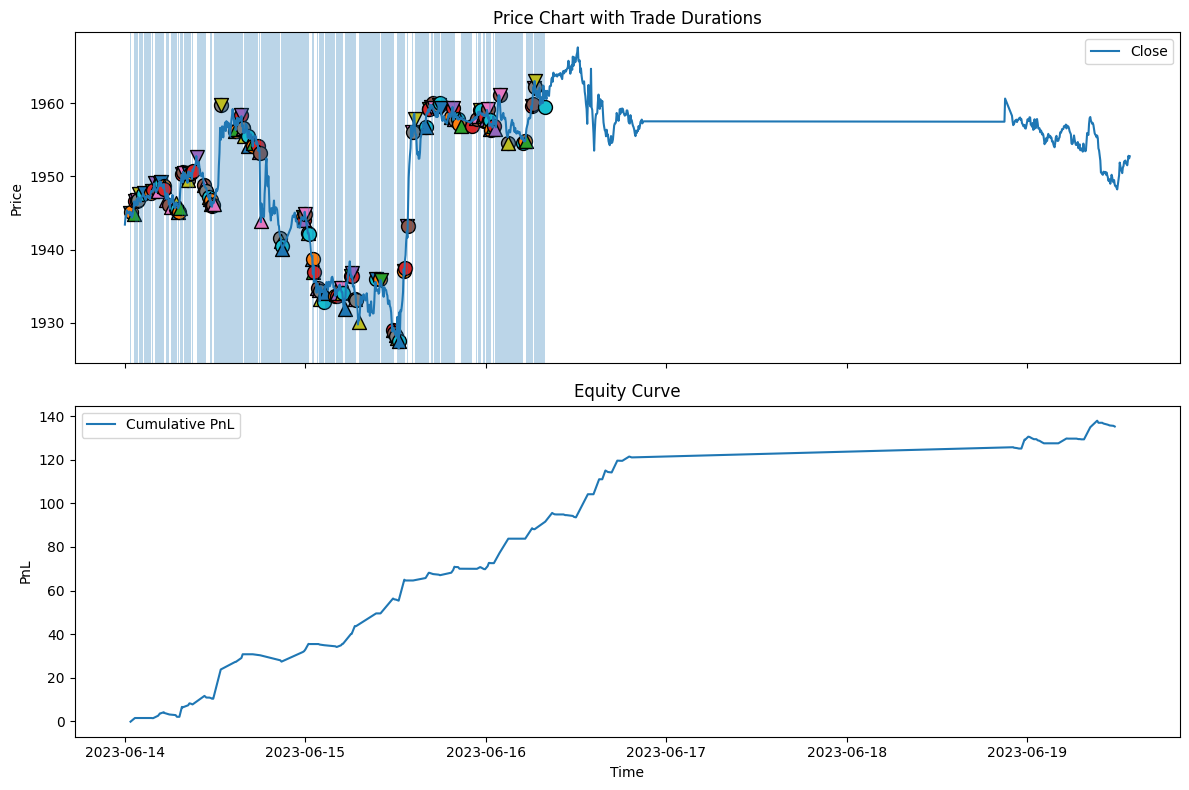

In [20]:
# assuming `bt` is your backtester instance:
bt = BacktesterWithoutScaling(data=df, lag=5, window=10)
bt.run_backtest()
bt.plot_trades_improved(n_trades=100)

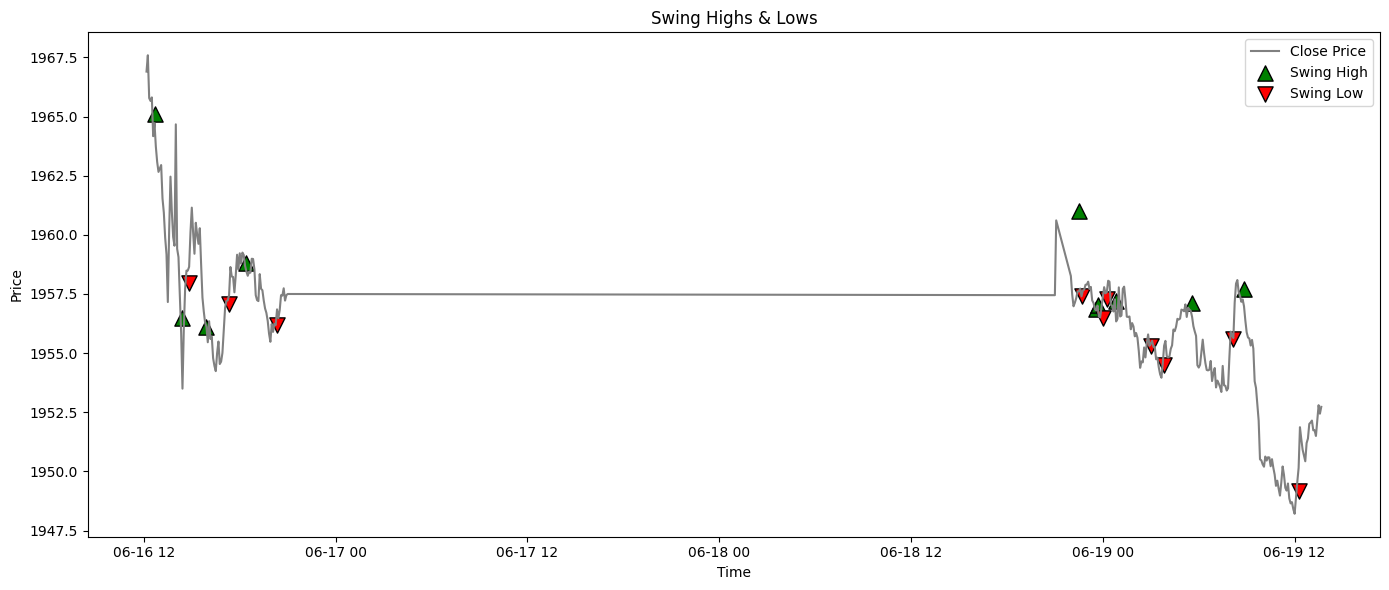

In [21]:

bt.plot_swings(show_window=300)  # Show last 300 bars with swings
